<a href="https://colab.research.google.com/github/aspendlo92/spendlove-capstone/blob/main/Spendlove_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions to Answer:

## What is your name?

### Andy Spendlove

## What is your question?

### Is there a significant short-term trend or anomaly in the mean temperature in Delhi over the first few months of 2017?

## Describe your dataset, including the URL

### This is a small, simple dataset showing mean temperature (Celsius), humidity (units are grams of water vapor per cubic meter volume of air), wind speed (km/h), and air pressure (atm) in Delhi from Jan 1, 2017 to April 24, 2017.
### https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

## What is(are) your independent variable(s) and dependent variable(s)?

### My dependent variable is mean temperature (continuous), and my main independent variable is the date (temporal/continuous). I will also include exogenous regressors such as humidity (continuous) and air pressure (continuous) in the model.

## Are your variables suitable for the analysis method (time-series)?

### All variables are appropriate for the ARIMA method: the mean temperature as the dependent variable is continuous, date provides a natural time index for the time-series analysis, and humidity and air pressure should be helpful exogenous regressors that can explain variations in temperature beyond what can be explained by time alone.



## What are your conclusions?

### The ADF, ACF, and PACF tests/plots in chunks 18, 19, and 20 showed that we were dealing with an ARIMA(0,0,0) (white noise) case, where the data was. The ARIMA model performed a little better than the OLS model, as we can see from the slightly lower AIC value in code chunk 28, which means it strikes a better balance between fit and simplicity. However, neither model explained much of the variation in temperature, with pseudo R-squared values showing that both models only account for around 9-10% of the variance (see: code chunk 27 calculating R-squared values). The coefficients showed that humidity decreases temperature while mean pressure increases it, and both relationships were statistically significant (chunks 16 and 24).

## What are your assumptions and limitations? What robustness checks did you perform or would you perform?

In [12]:
# Install necessary packages
#install.packages("ggplot2")
#install.packages("dplyr")
#install.packages("lubridate")
#install.packages("car")
#install.packages("forecast")
#install.packages("tseries")

# Load libraries
library(ggplot2)
library(dplyr)
library(lubridate)
library(car)
library(forecast)
library(tseries)

In [10]:
# Load the CSV data
climate <- read.csv('/content/DailyDelhiClimateTest.csv')

head(climate)

,date,meantemp,humidity,wind_speed,meanpressure
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017-01-01,15.91304,85.86957,2.743478,59.000
2,2017-01-02,18.50000,77.22222,2.894444,1018.278
3,2017-01-03,17.11111,81.88889,4.016667,1018.333
4,2017-01-04,18.70000,70.05000,4.545000,1015.700
5,2017-01-05,18.38889,74.94444,3.300000,1014.333
6,2017-01-06,19.31818,79.31818,8.681818,1011.773


In [11]:
# Convert the DATE column to Date type
climate$date <- as.Date(climate$date)

# Get the range of the date column
date_range <- range(climate$date)

# Print the result
date_range

[1] "2017-01-01" "2017-04-24"

In [16]:
# Calculate percentage change in mean temperature
climate <- climate %>%
  arrange(date) %>%
  mutate(temp_pct_change = (meantemp - lag(meantemp)) / lag(meantemp) * 100)

# Remove NA values caused by the lag function
climate <- climate %>%
  filter(!is.na(temp_pct_change))

# Now, let's run a simple linear regression to model how temperature changes over time, including exogenous variable humidity and meanpressure.
model <- lm(temp_pct_change ~ as.numeric(date) + humidity + meanpressure, data = climate)

# View the summary of the regression
summary(model)


Call:
lm(formula = temp_pct_change ~ as.numeric(date) + humidity + 
    meanpressure, data = climate)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.7220  -4.1530  -0.4331   4.7443  22.5744 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)       503.53617 1356.42002   0.371  0.71120   
as.numeric(date)   -0.06005    0.06959  -0.863  0.39012   
humidity           -0.27896    0.10177  -2.741  0.00717 **
meanpressure        0.54050    0.25615   2.110  0.03716 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.366 on 108 degrees of freedom
Multiple R-squared:  0.09848,	Adjusted R-squared:  0.07344 
F-statistic: 3.932 on 3 and 108 DF,  p-value: 0.01046


### Humidity and air pressure are showing as significant, while the date isn't, according to this simple linear model.
### The coefficient for humidity indicates that, for every 1 unit increase in humidity (units are grams of water vapor per cubic meter volume of air), the percentage change in temperature is expected to decrease by 0.278%.
### The coefficient for meanpressure indicates that, for every 1 unit increase in meanpressure (measured in atm), the percentage change in temperature is expected to increase by 0.540%.

In [17]:
# Durbin-Watson Test for autocorrelation
durbinWatsonTest(model)

 lag Autocorrelation D-W Statistic p-value
   1     -0.06278861      2.115929     0.7
 Alternative hypothesis: rho != 0

### The large p-value of 0.7 means we have no evidence to suggest that there is autocorrelation in the residuals, and thus, the residuals can be considered independent over time. Also, the D-W statistic (2.116) is close to 2, which is what we would expect if the residuals were uncorrelated (independent).

In [18]:
# Perform the Augmented Dickey-Fuller test on GDP percent change
adf_test_result <- adf.test(climate$temp_pct_change)

# Print the result
print(adf_test_result)

Warning message in adf.test(climate$temp_pct_change):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  climate$temp_pct_change
Dickey-Fuller = -5.9752, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



### The test statistic of -5.97 is quite negative, which, alongside the very low p-value of 0.01, strongly suggests that our time series is stationary, so there is no need for a difference score and d will equal 0 in our ARIMA code.

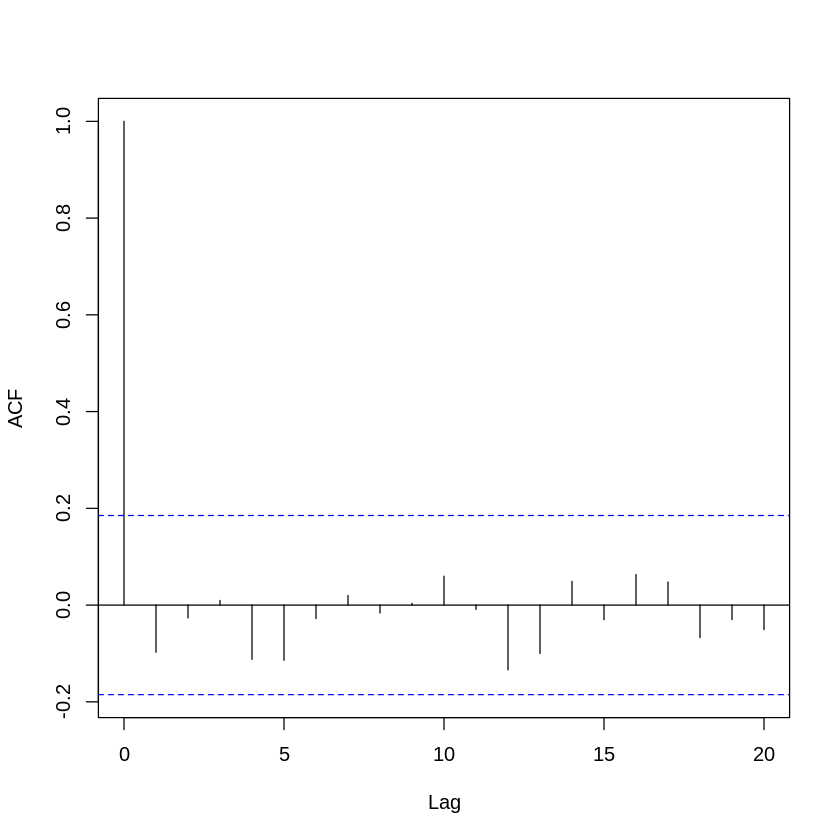

In [19]:
acf((climate$temp_pct_change), main='')

### Since none of the vertical lines at any lag (other than lag 0) cross the ±0.2 thresholds, this suggests that there is no significant autocorrelation at any of the lags. From what I understand, this suggests that the time series does not exhibit strong correlations with its past values, at least based on this plot. This could mean that the time series is relatively independent of past values. It also means that q=0.

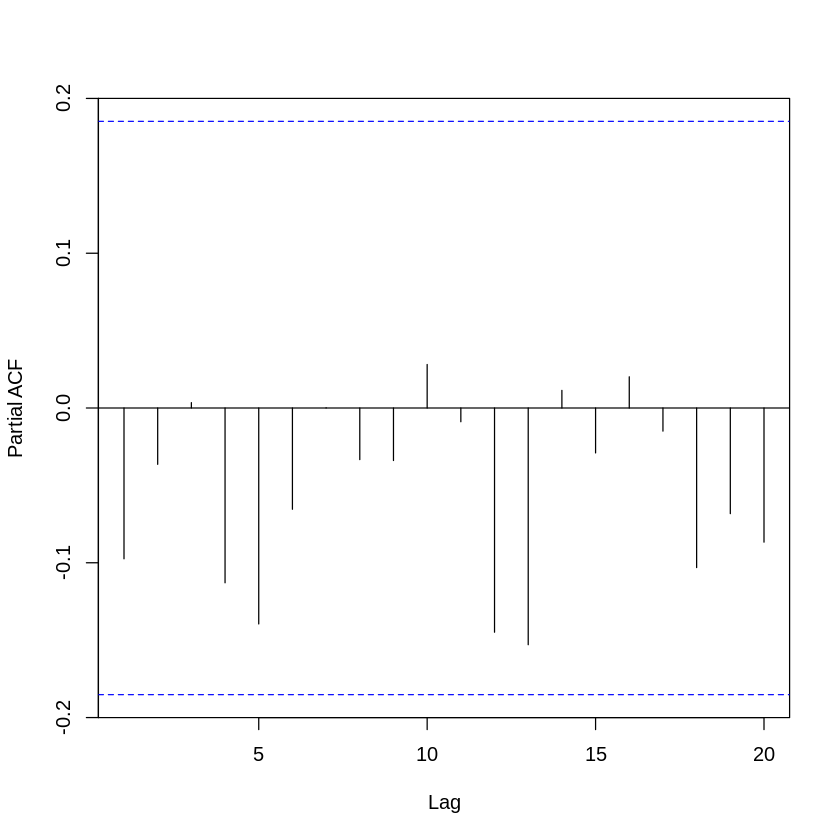

In [20]:
pacf((climate$temp_pct_change), main='')

### Since none of the vertical lines cross the threshold, including lag 0 this time, the plot suggests that the past values don't explain the current value in a meaningful way when accounting for earlier time points. p=0

### I researched a bit into what it means if d, q, and p all equal zero like we have here, and it seems to be referred to as a white noise model, where the time series is essentially modeled as white noise (random fluctuations without any discernible pattern), meaning the series doesn't show significant structure that could be captured by AR or MA terms.
### Knowing that we're dealing with a white noise model could by itself answer our initial question, that there is no time-based trend or anomaly in our data over its short time period from 1/1/17 to 4/24/17. If I was in a climate analyst whose job it was to make sure no such anomalies are present, this could actually be very useful and good news. But certainly let's still carry out the manual ARIMA model to see what it says.

In [23]:
# Run Manual ARIMA
xreg <- model.matrix(~ humidity + meanpressure, data = climate)[, -1]

manual_ARIMA<-arima(climate$temp_pct_change, order=c(0,0,0), xreg = xreg)
summary(manual_ARIMA)


Call:
arima(x = climate$temp_pct_change, order = c(0, 0, 0), xreg = xreg)

Coefficients:
      intercept  humidity  meanpressure
      -651.6626   -0.2120        0.6563
s.e.   214.8973    0.0649        0.2150

sigma^2 estimated as 67.96:  log likelihood = -395.18,  aic = 798.37

Training set error measures:
                        ME     RMSE      MAE  MPE MAPE      MASE       ACF1
Training set -1.410392e-12 8.243985 6.200934 -Inf  Inf 0.6465357 -0.0954994

The manual ARIMA outperformed the auto ARIMA (AIC 214 vs 228) so I'll stick with manual.

In [21]:
# Run auto-ARIMA
xreg <- model.matrix(~ humidity + meanpressure, data = climate)[, -1]

arima_model <- auto.arima(climate$temp_pct_change, xreg = xreg)
summary(arima_model)

Series: climate$temp_pct_change 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept  humidity  meanpressure
      -651.6626   -0.2120        0.6563
s.e.   214.8973    0.0649        0.2150

sigma^2 = 69.83:  log likelihood = -395.18
AIC=798.37   AICc=798.74   BIC=809.24

Training set error measures:
                        ME     RMSE      MAE  MPE MAPE      MASE       ACF1
Training set -1.410392e-12 8.243985 6.200934 -Inf  Inf 0.6465357 -0.0954994

### The output for the manual ARIMA and auto ARIMA are the same, which is what is expected when we're dealing with an ARIMA(0,0,0) case like this. The model is effectively a simple regression model with white noise errors. The significant predictor is mean pressure with a positive influence on temperature change, while humidity has a small but negative effect. Since the model uses white noise errors, the time series doesn't exhibit meaningful autocorrelation.

In [24]:
# Extract the coefficients and standard errors
coefs <- coef(manual_ARIMA)
se <- sqrt(diag(vcov(manual_ARIMA)))

# Calculate z-statistics
z_values <- coefs / se

# Calculate p-values (two-tailed test)
p_values <- 2 * pnorm(abs(z_values), lower.tail = FALSE)

# Combine coefficients, standard errors, z-values, and p-values into a data frame
results <- data.frame(Coefficient = coefs, `Standard Error` = se, `Z-value` = z_values, `P-value` = p_values)

# Print results
print(results)

              Coefficient Standard.Error   Z.value     P.value
intercept    -651.6625594   214.89732517 -3.032437 0.002425879
humidity       -0.2119857     0.06486098 -3.268308 0.001081925
meanpressure    0.6562586     0.21501767  3.052115 0.002272351


### Humidity and air pressure are again showing as being statistically significant, with very low p-values (0.001 and 0.002, respectively), like they were in our simple linear model from earlier.


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0) with non-zero mean
Q* = 7.7201, df = 10, p-value = 0.6562

Model df: 0.   Total lags used: 10



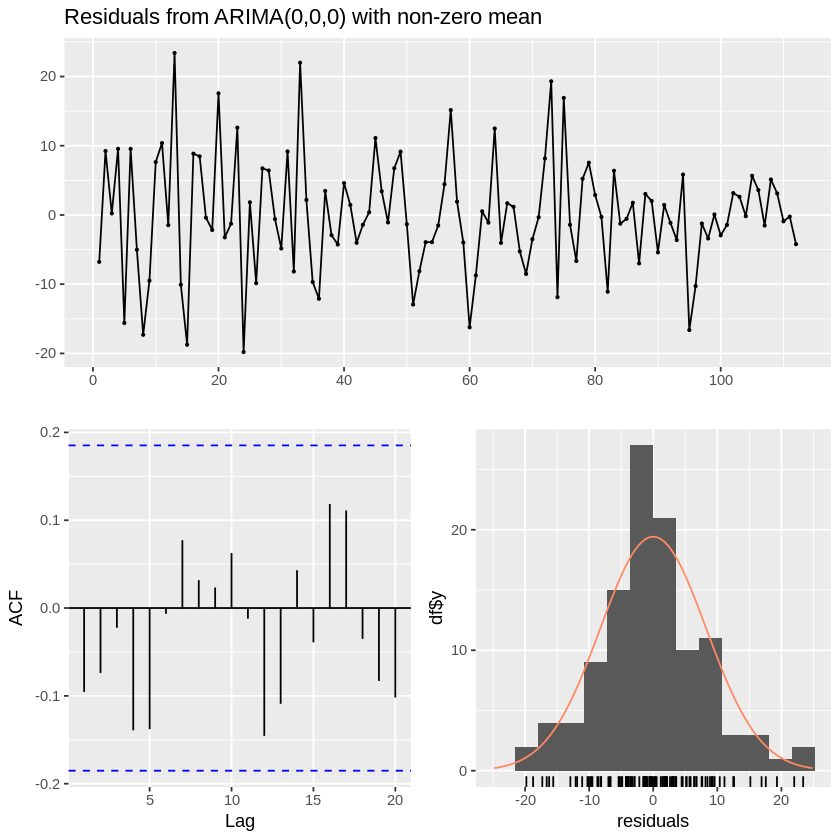

In [25]:
checkresiduals(manual_ARIMA)

### Since the p-value (0.6562) is really high, we fail to reject the null hypothesis. This means that there is no evidence of significant autocorrelation in the residuals, and the residuals appear to be random (white noise).

In [27]:
# Calculate the residuals for ARIMA model
arima_resid <- residuals(manual_ARIMA)

# Pseudo R-squared
pseudo_r_squared_arima <- 1 - var(arima_resid) / var(climate$temp_pct_change)

cat("ARIMA Pseudo R-squared", pseudo_r_squared_arima, "\n")
cat("OLS R-squared", summary(model)$r.squared)

ARIMA Pseudo R-squared 0.09226336 
OLS R-squared 0.09847852

### Both models explain a very similarly low percentage of the variation in our dependent variable: only about 9%. This could be due to the very small range of dates available in this dataset, or that we're missing some significant variables in explaining the temperature's percent change over time.

In [ ]:
# Residuals from the ARIMA model
arima_resid <- residuals(manual_ARIMA)

# Total variance of the original time series
total_variance <- var(gdp_filtered$gdp_pct_change)

# Residual variance of the ARIMA model
residual_variance <- var(arima_resid)

# Number of observations
n <- length(gdp_filtered$gdp_pct_change)

# Number of parameters in the ARIMA model (p = AR + MA + differencing terms)
p <- length(manual_ARIMA$coef) + manual_ARIMA$arma[6]

# Adjusted Pseudo R-squared
adjusted_pseudo_r_squared <- 1 - (residual_variance / total_variance) * (n - 1) / (n - p - 1)

# Print the result
cat("ARIMA Adjusted Pseudo R-squared:", adjusted_pseudo_r_squared, "\n")
cat("OLS Adjusted R-squared", summary(model)$adj.r.squared)

ARIMA Adjusted Pseudo R-squared: 0.2870026 
OLS Adjusted R-squared -0.06379384

### The ARIMA Adjusted Pseudo R-squared of 0.28 is much greater than the OLS Adjusted R-squared of -0.06. So, the ARIMA model appears to be a better fit for our data compared to the OLS regression. While the ARIMA model is not perfect (the pseudo R-squared value is still pretty small), it is a significant improvement over the OLS regression.

In [28]:
# AIC for ARIMA model
AIC_arima <- AIC(manual_ARIMA)

# AIC for OLS model
AIC_ols <- AIC(model)

# Compare AIC values
cat("ARIMA AIC", AIC_arima, "\n")
cat("OLS AIC", AIC_ols)

ARIMA AIC 798.3666 
OLS AIC 799.5971

### This output suggests that both models have a similar fit, but the ARIMA model is slightly better.

In [30]:
# For ARIMA model: Forecast on the same data
arima_fitted <- fitted(manual_ARIMA)

# For OLS model: Get the fitted values
ols_fitted <- fitted(model)

# Calculate RMSE for ARIMA
rmse_arima <- sqrt(mean((climate$temp_pct_change - arima_fitted)^2))

# Calculate RMSE for OLS
rmse_ols <- sqrt(mean((climate$temp_pct_change - ols_fitted)^2))

# Compare RMSE
rmse_arima
rmse_ols

[1] 8.243985

[1] 8.215713